In [4]:
#!pip install squarify
#!pip install textacy
import nltk
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_sm')
from  textacy import preprocessing as tprep

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import os
os.chdir('C:/Users/T430/Google Drive/00 - Masters/Disseration/00 - Actual Disseration')

I hadn't realised it didn't have headings. E, F, G, H represent the following data:

'like_count', 'quote_count', 'reply_count','retweet_count'

In [5]:
import pandas as pd
df = pd.DataFrame()
for i in range(2016,2021):
    df_read = pd.read_csv(f'data/{i}_ryan_data.csv')
    df = df.append(df_read)

### 1.0 Remove all tweets that begin with "Current price:"

In [7]:
df = df[~df.text.str.contains('Current price:')]
df = df[~df.text.str.contains('Current price')]
df = df[~df.text.str.contains('current price')]
df = df[~df.text.str.contains('current rate:')]
df = df[~df.text.str.contains('Current rate:')]
df = df[~df.text.str.contains(r'[0-9]')]

In [8]:
#keep only tweets that contain $BTC

In [9]:
df = df.reset_index(drop=True)

In [10]:
df

,id1,date,nothing,id2,like_count,quote_count,reply_count,retweet_count,text,Unnamed: 9
0,2.231450e+09,2016-01-02 22:46:02+00:00,,6.834190e+17,0,0,0,0,BUY #bitcoin $BTC,False
1,2.356524e+09,2016-01-02 18:05:59+00:00,,6.833490e+17,0,0,0,0,"$CTXS Information for Citrix Systems, Inc.\nFr...",False
2,2.356524e+09,2016-01-02 18:04:12+00:00,,6.833480e+17,0,0,0,0,$CLW Information for Clearwater Paper Corporat...,False
3,2.356524e+09,2016-01-02 18:03:26+00:00,,6.833480e+17,0,0,0,0,$INTC Information for Intel Corp.\nFrom our St...,False
4,2.356524e+09,2016-01-02 18:02:11+00:00,,6.833480e+17,0,0,0,0,$CLNE Information for Clean Energy Fuels Corp....,False
...,...,...,...,...,...,...,...,...,...,...
138041,2.263133e+07,2020-12-29 20:37:48+00:00,,1.344020e+18,1,0,2,0,I still believe more words of Ripple than most...,False
138042,1.137140e+18,2020-12-29 20:35:48+00:00,,1.344020e+18,2,0,2,0,Is the SEC saying that all of the $XRP Ripple ...,False
138043,9.742810e+17,2020-12-29 20:35:33+00:00,,1.344020e+18,6,0,2,0,Doing our part to keep $AMC alive. Rented out ...,False
138044,7.634180e+17,2020-12-29 20:35:21+00:00,,1.344020e+18,735,11,109,66,It is now too risky to hold any investment tha...,False


### 1.1 Clean tweets

Now we clean the tweets so they don't impact the analysis. The following steps were taken so tweets and the words are cleaned. If there are any characters next to valid words that may impact how we count up the frequency of words. For example, we eliminate brackets from this text "(good)" to make "good" and therefore the original text can be bundled with the other words "good" in corpus.

Here are the steps we will take to clean up the text, again using regular expressions:

1. Convert html expressions such as \n and &amp; to characters
2. Delete any html tags such as <'tab'>
3. We will keep URLS as they may help for the classification in Task D. Sometimes it's good to remove URLS from a text however in this case perhaps certain tweets with misinformation often link to a website so it could be possible that a URL helps to predict a tweet with misinformation.
4. Eliminate any brackets
5. Clean up hashes that don't form a hashtag. So we remove a text like this: &#- but we keep text like this "#hello".
6. Clean up hyphens
7. Clean up white spaces to just one white space

We create a program that creates the above steps and after we apply that to the data.

Here is a program that will clean up the text:

In [11]:
import html

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    #no hashtags
    #text = re.sub('\#[\w\_]+',' ', text)
    #no dollar
    #text = re.sub('\$[\w\_]+',' ', text)
    return text.strip()

Apply the cleaning program we just created to all the tweets and call these cleaned tweets "clean_text" in our dataframe.

In [12]:
df['text1'] = df['text'].map(clean)

In [13]:
for i in range(10):
    print("---------------","\n","Tweet number", i, "\n","--------------")
    print(df['text'][i],"---->",df['text1'][i])

--------------- 
 Tweet number 0 
 --------------
BUY #bitcoin $BTC ----> BUY #bitcoin $BTC
--------------- 
 Tweet number 1 
 --------------
$CTXS Information for Citrix Systems, Inc.
From our Stock News Alerts App ----> $CTXS Information for Citrix Systems, Inc. From our Stock News Alerts App
--------------- 
 Tweet number 2 
 --------------
$CLW Information for Clearwater Paper Corporation
From our Stock News Alerts App ----> $CLW Information for Clearwater Paper Corporation From our Stock News Alerts App
--------------- 
 Tweet number 3 
 --------------
$INTC Information for Intel Corp.
From our Stock News Alerts App ----> $INTC Information for Intel Corp. From our Stock News Alerts App
--------------- 
 Tweet number 4 
 --------------
$CLNE Information for Clean Energy Fuels Corp.
From our Stock News Alerts App ----> $CLNE Information for Clean Energy Fuels Corp. From our Stock News Alerts App
--------------- 
 Tweet number 5 
 --------------
SELL #bitcoin $BTC ----> SELL #bitcoin

### 1.2 Convert all tweets to lowercase for tokenisation
We convert to lowercase so words like "corona" and "Corona" which means in the analysis both words come under the label "corona". This is important because we don't want these to be treated as two different words just because one is capitalised - that would make the statistical analysis weaker.

In [14]:
df = df.applymap(lambda s:s.lower() if type(s) == str else s) #convert all to lowercase


In [15]:
df['text1'][2]

'$clw information for clearwater paper corporation from our stock news alerts app'

In [16]:
df_btc = df[df.text1.str.contains('btc|bitcoin', na=False)]
df_btc = df_btc.reset_index(drop=True)

In [121]:
#delete words i don't think are useful to the analysis

import re
To_remove_lst =['btc','bitcoin', '$btc', 'crypto', 'cryptocurrency']
p = re.compile('|'.join(map(re.escape, To_remove_lst)))
df_btc['text1'] = [p.sub('', text) for text in df_btc['text1']] 

In [132]:
len(df_btc)

85491

In [17]:
#sample down for speed
df = df_btc.sample(frac=0.1, replace=True, random_state=1)
df = df.reset_index(drop=True)

### Delete stopwords

In [18]:
df['text2'] = df['text1'].map(nlp)


In [19]:
def stop_words(doc):
    non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
    return non_stop
df['text3'] = df['text2'].map(stop_words)


### 1.3 Keep only tweets that contain BTC

In [20]:
df['text3']

0                     [interesting, btc, $, btc, bitcoin]
1       [start, feel, sdr, feature, blockchain, coming...
2       [forget, pray, jesus, mohammed, trump, bitcoin...
3       [$, btc, futures, algorhithmic, beat, days, ki...
4                  [btc, $, btc, bitcoin, $, bcc, crypto]
                              ...                        
8544    [banks, institutions, lenders, eyeing, digital...
8545    [$, btc, $, ltc, $, eth, fuc, shorting, right,...
8546         [btc, $, btc, let, watch, world, burn, boys]
8547                                       [$, btc, boom]
8548    [governments, banks, associating, crypto, ille...
Name: text3, Length: 8549, dtype: object

## 1.4 From https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization

In [21]:
%pylab inline

import pandas as pd
import pickle as pk
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


In [22]:
df['text4'] = [' '.join(map(str, l)) for l in df['text3']]

In [23]:
df['text4']

0                           interesting btc $ btc bitcoin
1       start feel sdr feature blockchain coming soon ...
2       forget pray jesus mohammed trump bitcoin $ btc...
3       $ btc futures algorhithmic beat days kind danc...
4                          btc $ btc bitcoin $ bcc crypto
                              ...                        
8544    banks institutions lenders eyeing digital asse...
8545    $ btc $ ltc $ eth fuc shorting right people kn...
8546                  btc $ btc let watch world burn boys
8547                                           $ btc boom
8548    governments banks associating crypto illegal m...
Name: text4, Length: 8549, dtype: object

In [24]:
docs = array(df['text4'])


In [25]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

In [26]:
docs = docs_preprocessor(docs)

In [27]:
from gensim.models import Phrases
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [28]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 8897
Number of unique words after removing rare and common words: 1146


In [29]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [30]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1146
Number of documents: 8549


In [31]:
from gensim.models import LdaModel

In [32]:
# Set training parameters.
num_topics = 8
chunksize = 500 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)





Wall time: 1min 47s


In [33]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.109060 -0.234841       1        1  20.298496
2     -0.322137  0.040090       2        1  18.079408
3      0.114495  0.302555       3        1  15.153722
0      0.113159 -0.151830       4        1  12.608709
5      0.097246  0.219297       5        1   9.518802
7      0.087630 -0.084039       6        1   9.238692
6      0.070146 -0.051484       7        1   7.603769
1     -0.269599 -0.039748       8        1   7.498402, topic_info=               Term         Freq        Total Category  logprob  loglift
17           crypto  1809.000000  1809.000000  Default  30.0000  30.0000
143            like   590.000000   590.000000  Default  29.0000  29.0000
20             time   525.000000   525.000000  Default  28.0000  28.0000
34              alt   661.000000   661.000000  Default  27.0000  27.0000
43            going   427.000000   427.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
765           print    34.144941    35.014515   Topic8  -4.6893   2.5653
250            half    33.313846    34.179275   Topic8  -4.7139   2.5648
87           couple    29.966421    30.831389   Topic8  -4.8198   2.5620
1        blockchain   181.451393   258.895151   Topic8  -3.0189   2.2350
36   cryptocurrency   148.555489   545.061861   Topic8  -3.2189   1.2905

[277 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
34        1  0.997985       alt
311       2  0.995569   altcoin
117       1  0.993457  altcoins
484       7  0.990546  analysis
415       4  0.985057   anymore
...     ...       ...       ...
306       3  0.978491     whale
132       4  0.995880      work
133       4  0.993318     world
73        1  0.990442     worth
159       2  0.989731      year

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 6, 8, 7, 2])

In [81]:
import gensim
model = gensim.models.ldamodel.LdaModel(corpus, num_topics=8, id2word=id2word, passes=20, alpha='auto', eta='auto')
model.save('gensim_model.gensim')

In [90]:
print(model)

LdaModel(num_terms=1146, num_topics=8, decay=0.5, chunksize=2000)


In [93]:
import pickle

pickle.dump(corpus, open('gensim_corpus_corpus.pkl', 'wb'))
dictionary.save('gensim_dictionary.gensim')

In [100]:
#model.eta
model.alpha

array([0.24781024, 0.16269827, 0.26769352, 0.20336135, 0.33341604,
       0.18528914, 0.18326369, 0.22934502], dtype=float32)

In [95]:
pickle.dump(model, open('model.pkl', 'wb'))

In [82]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.228177  0.143856       1        1  16.813472
2     -0.072297 -0.048831       2        1  16.702195
0      0.222900  0.141108       3        1  12.921434
7      0.003702 -0.044915       4        1  12.024417
3     -0.119442  0.111853       5        1  11.603058
6     -0.230076  0.080383       6        1  10.925120
5     -0.143287 -0.025693       7        1   9.989081
1      0.110323 -0.357761       8        1   9.021224, topic_info=               Term        Freq       Total Category  logprob  loglift
44           market  593.000000  593.000000  Default  30.0000  30.0000
143            like  571.000000  571.000000  Default  29.0000  29.0000
214            long  352.000000  352.000000  Default  28.0000  28.0000
36   cryptocurrency  502.000000  502.000000  Default  27.0000  27.0000
34              alt  585.000000  585.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
227           short   51.302180  333.699503   Topic8  -4.4671   0.5331
305           think   46.001193  305.537460   Topic8  -4.5761   0.5122
122           ready   34.112937  134.920670   Topic8  -4.8751   1.0306
162        exchange   34.529345  153.390979   Topic8  -4.8630   0.9144
562           close   29.787413   90.978831   Topic8  -5.0107   1.2890

[438 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
627       8  0.935481        accept
574       3  0.984883    accumulate
299       6  0.953861  accumulating
686       3  0.151210        action
686       5  0.831655        action
...     ...       ...           ...
133       2  0.988384         world
159       2  0.172476          year
159       3  0.503630          year
159       4  0.324255          year
373       4  0.978119     yesterday

[646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 8, 4, 7, 6, 2])

In [38]:
df

,id1,date,nothing,id2,like_count,quote_count,reply_count,retweet_count,text,Unnamed: 9,text1,text2,text3,text4
0,7.804300e+17,2020-07-06 23:34:37+00:00,,1.280280e+18,0,0,0,0,this could get interesting #btc $btc #bitcoin,False,this could get interesting #btc $btc #bitcoin,"(this, could, get, interesting, #, btc, $, btc...","[interesting, btc, $, btc, bitcoin]",interesting btc $ btc bitcoin
1,2.179762e+09,2017-04-04 10:03:17+00:00,,8.492010e+17,1,0,0,0,i start to feel some #sdr feature of #blockcha...,False,i start to feel some #sdr feature of #blockcha...,"(i, start, to, feel, some, #, sdr, feature, of...","[start, feel, sdr, feature, blockchain, coming...",start feel sdr feature blockchain coming soon ...
2,1.983793e+08,2019-01-06 19:21:09+00:00,,1.081990e+18,0,0,0,0,don’t forget to #pray #jesus #mohammed #trump ...,False,don’t forget to #pray #jesus #mohammed #trump ...,"(do, n’t, forget, to, #, pray, #, jesus, #, mo...","[forget, pray, jesus, mohammed, trump, bitcoin...",forget pray jesus mohammed trump bitcoin $ btc...
3,8.120320e+17,2020-03-18 23:52:08+00:00,,1.240430e+18,0,0,0,0,$btc futures in an algorhithmic beat for a few...,False,$btc futures in an algorhithmic beat for a few...,"($, btc, futures, in, an, algorhithmic, beat, ...","[$, btc, futures, algorhithmic, beat, days, ki...",$ btc futures algorhithmic beat days kind danc...
4,2.615655e+08,2017-08-02 01:40:42+00:00,,8.925610e+17,1,0,0,1,what is next? #btc $btc #bitcoin $bcc #crypto,False,what is next? #btc $btc #bitcoin $bcc #crypto,"(what, is, next, ?, #, btc, $, btc, #, bitcoin...","[btc, $, btc, bitcoin, $, bcc, crypto]",btc $ btc bitcoin $ bcc crypto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8544,7.362730e+17,2019-04-22 23:36:16+00:00,,1.120470e+18,0,0,0,0,"now that banks, institutions, and lenders are ...",False,"now that banks, institutions, and lenders are ...","(now, that, banks, ,, institutions, ,, and, le...","[banks, institutions, lenders, eyeing, digital...",banks institutions lenders eyeing digital asse...
8545,9.968360e+17,2019-04-02 19:53:40+00:00,,1.113170e+18,5,0,0,0,$btc $ltc $eth who the fuc is shorting these r...,False,$btc $ltc $eth who the fuc is shorting these r...,"($, btc, $, ltc, $, eth, who, the, fuc, is, sh...","[$, btc, $, ltc, $, eth, fuc, shorting, right,...",$ btc $ ltc $ eth fuc shorting right people kn...
8546,2.314448e+09,2016-06-16 15:49:38+00:00,,7.434710e+17,0,0,0,0,#btc $btc let's watch the world burn boys,False,#btc $btc let's watch the world burn boys,"(#, btc, $, btc, let, 's, watch, the, world, b...","[btc, $, btc, let, watch, world, burn, boys]",btc $ btc let watch world burn boys
8547,2.579866e+08,2020-03-18 21:15:17+00:00,,1.240390e+18,0,0,0,0,$btc about to boom,False,$btc about to boom,"($, btc, about, to, boom)","[$, btc, boom]",$ btc boom


In [39]:
from sklearn.metrics.pairwise import cosine_similarity

df['tokenz'] = docs

docs1 = df['tokenz'].apply(lambda l: l[:int0(len(l)/2)])
docs2 = df['tokenz'].apply(lambda l: l[int0(len(l)/2):])

In [40]:
corpus1 = [dictionary.doc2bow(doc) for doc in docs1]
corpus2 = [dictionary.doc2bow(doc) for doc in docs2]

# Using the corpus LDA model tranformation
lda_corpus1 = model[corpus1]
lda_corpus2 = model[corpus2]

In [41]:
from collections import OrderedDict
def get_doc_topic_dist(model, corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [array(vals)]
        if kwords:
            keys += [array(vals).argmax()]

    return array(top_dist), keys

In [42]:
top_dist1, _ = get_doc_topic_dist(model, lda_corpus1)
top_dist2, _ = get_doc_topic_dist(model, lda_corpus2)

print("Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):")
print(mean([cosine_similarity(c1.reshape(1, -1), c2.reshape(1, -1))[0][0] for c1,c2 in zip(top_dist1, top_dist2)]))

random_pairs = np.random.randint(0, len(df['text']), size=(400, 2))

print("Inter similarity: cosine similarity between random parts (lower is better):")
print(np.mean([cosine_similarity(top_dist1[i[0]].reshape(1, -1), top_dist2[i[1]].reshape(1, -1)) for i in random_pairs]))


Intra similarity: cosine similarity for corresponding parts of a doc(higher is better):
0.7711534
Inter similarity: cosine similarity between random parts (lower is better):
0.69789624


In [43]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [44]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

short                0.055
long                 0.046
short_term           0.035
long_term            0.028
term                 0.024
crypto               0.023
time                 0.021
need                 0.019
go                   0.017
know                 0.015
Topic 1 |---------------------

going                0.049
alt                  0.044
pump                 0.039
altcoins             0.035
crypto               0.033
news                 0.025
price                0.022
coin                 0.015
fomo                 0.015
price_action         0.013
Topic 2 |---------------------

bitcoin_ethereum     0.057
coin                 0.051
crypto               0.046
link                 0.036
ethereum             0.034
looking              0.021
money                0.021
chart                0.016
litecoin             0.015
cryptocurrency       0.011
Topic 3 |---------------------

market               0.082
cry

In [45]:
top_labels = {0: 'one', 1:'two', 2:'three', 3:'four', 4:'five', 5:'six', 6:'seven', 7:'eight'}

In [46]:
import re
import nltk

from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

def paper_to_wordlist( paper, remove_stopwords=True ):
    '''
        Function converts text to a sequence of words,
        Returns a list of words.
    '''
    lemmatizer = WordNetLemmatizer()
    # 1. Remove non-letters
    paper_text = re.sub("[^a-zA-Z]"," ", paper)
    # 2. Convert words to lower case and split them
    words = paper_text.lower().split()
    # 3. Remove stop words
    words = [w for w in words if not w in stops]
    # 4. Remove short words
    words = [t for t in words if len(t) > 2]
    # 5. lemmatizing
    words = [nltk.stem.WordNetLemmatizer().lemmatize(t) for t in words]

    return(words)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',\
                                  tokenizer=paper_to_wordlist, ngram_range=(1, 3), min_df=40, max_df=0.20,\
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)

dtm = tvectorizer.fit_transform(df['text']).toarray()

C:\Users\T430\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [48]:
top_dist =[]
for d in corpus:
    tmp = {i:0 for i in range(num_topics)}
    tmp.update(dict(model[d]))
    vals = list(OrderedDict(tmp).values())
    top_dist += [array(vals)]

In [49]:
top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)
features = tvectorizer.get_feature_names()

In [50]:
top_ws = []
for n in range(len(dtm)):
    inds = int0(argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]
    
    top_ws += [' '.join(tmp)]
    
df['Text_Rep'] = pd.DataFrame(top_ws)
df['clusters'] = pd.DataFrame(lda_keys)
df['clusters'].fillna(10, inplace=True)

cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue', 5:'salmon', 6:'orange', 7:'maroon'} #, 8:'crimson', 9:'black', 10:'gray'}

df['colors'] = df['clusters'].apply(lambda l: cluster_colors[l])

In [51]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(top_dist)

In [52]:
df['X_tsne'] =X_tsne[:, 0]
df['Y_tsne'] =X_tsne[:, 1]

In [53]:
from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [54]:
source = ColumnDataSource(dict(
    x=df['X_tsne'],
    y=df['Y_tsne'],
    color=df['colors'],
    label=df['clusters'].apply(lambda l: top_labels[l]),
#     msize= p_df['marker_size'],
    topic_key= df['clusters'],
    #title= df[u'Title'],
    content = df['text']
))


In [55]:
df['clusters'].unique()

array([1, 4, 3, 5, 7, 6, 2, 0], dtype=int64)

In [56]:
top_labels

{0: 'one',
 1: 'two',
 2: 'three',
 3: 'four',
 4: 'five',
 5: 'six',
 6: 'seven',
 7: 'eight'}

In [57]:
title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover", x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8, size=10)#'msize', )

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - Topic: @topic_key "}
plot_lda.legend.location = "top_left"

show(plot_lda)

#save the plot
# save(plot_lda, '{}.html'.format(title))

In [70]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:\\new_mallet\\mallet-2.0.8\\bin\\mallet' 
#You should update this path as per the path of Mallet directory on your system.

In [138]:
ldamallet = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus, num_topics=15, id2word=id2word
)



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\T430\\AppData\\Local\\Temp\\ef6c87_state.mallet.gz'

In [107]:
model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pyLDAvis.gensim_models.prepare(model2, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.079817 -0.227640       1        1  6.866258
6      0.010246  0.082428       2        1  6.826990
2     -0.097137  0.088669       3        1  6.724537
4     -0.063682  0.101525       4        1  6.713242
7      0.072049  0.049645       5        1  6.687925
8     -0.083458 -0.170665       6        1  6.679572
5      0.361361 -0.038673       7        1  6.678550
12    -0.078681  0.075672       8        1  6.654297
11    -0.078268 -0.221132       9        1  6.648991
0      0.368015 -0.028695      10        1  6.638535
13    -0.062120  0.172204      11        1  6.614792
3     -0.092188 -0.102034      12        1  6.579844
9     -0.034141  0.165111      13        1  6.571473
14    -0.061916  0.144670      14        1  6.562037
1     -0.080264 -0.091086      15        1  6.552957, topic_info=               Term         Freq        Total Category  logprob  loglift
17           crypto  1906.000000  1906.000000  Default  30.0000  30.0000
44           market   664.000000   664.000000  Default  29.0000  29.0000
20             time   659.000000   659.000000  Default  28.0000  28.0000
34              alt   654.000000   654.000000  Default  27.0000  27.0000
36   cryptocurrency   579.000000   579.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
902            poll    22.987328    27.614364  Topic15  -4.9502   2.5419
289            hodl    60.916420   170.988243  Topic15  -3.9756   1.6932
474         tonight    26.435427    42.514707  Topic15  -4.8104   2.2501
13           future    31.032893   182.207250  Topic15  -4.6501   0.9552
326           party    21.837962    45.225582  Topic15  -5.0015   1.9972

[730 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1089      9  1.004179        aapl
181      10  1.014765  absolutely
627       5  1.008411      accept
374       7  0.995013     account
574       4  0.027692  accumulate
...     ...       ...         ...
203       6  0.135961       wrong
159      11  1.002517        year
373      14  1.007979   yesterday
542      15  0.988687       zcash
407      12  1.008292        zone

[921 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 3, 5, 8, 9, 6, 13, 12, 1, 14, 4, 10, 15, 2])

### 2.3 Create a table so we can see which topic is assigned to each document

The following table shows the assigned topic to every single document. Only the first 10 rows are shown for brevity. To see the whole table delete "head(10)" from the very bottom of the follow code chunk.

In [133]:
data = df.text.values.tolist()
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    originalcont = pd.Series(df['text'])
    sent_topics_df = pd.concat([sent_topics_df, contents, originalcont], axis=1)
    return(sent_topics_df)



df_topic_sents_keywords = format_topics_sentences(ldamodel=model2, corpus=corpus, texts=docs)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original Text
0,0,7.0,0.0850,"week, project, day, good, month, opportunity, china, interesting, couple_day, token","[interesting, bitcoin]",this could get interesting #btc $btc #bitcoin
1,1,1.0,0.1393,"time, sell, high, coming, time_high, hard, making, happen, move, coming_soon","[start, feel, feature, blockchain, coming, soon, guess, basket, coming_soon, coming_soon, coming...",i start to feel some #sdr feature of #blockchain will coming soon. let guess who may in the bask...
2,2,0.0,0.0844,"crypto, people, strat, feel, feel_like, twitter, portfolio, moving, iota, drgn","[forget, pray, jesus, mohammed, trump, bitcoin]",don’t forget to #pray #jesus #mohammed #trump #bitcoin $btc 🦄🌈🚀🌙
3,3,8.0,0.1114,"money, trade, future, usdt, close, daily, trading, post, fuck, update","[future, algorhithmic, beat, day, kind, dance, good, trade]",$btc futures in an algorhithmic beat for a few days now\n\nthe kind of dance that's always good ...
4,4,5.0,0.0759,"crypto, great, world, game, invest, asset, understand, question, bank, idea","[bitcoin, crypto]",what is next? #btc $btc #bitcoin $bcc #crypto
5,5,14.0,0.0788,"altcoins, today, buying, waiting, love, holding, bought, selling, life, sold","[tanking, usdt, stress, come, time, good, safe, haven, crypto, safe_haven]","$btc tanking still, if you aren't in $usdt don't stress, it'll come back up in due time. $ltc &a..."
6,6,8.0,0.0833,"money, trade, future, usdt, close, daily, trading, post, fuck, update","[update, guy]",$btc any update guys?
7,7,12.0,0.0966,"price, stop, price_action, bag, wait, higher, follow, stop_loss, green, loss","[gaining, momentum, care, bag]",$btc seems to be gaining momentum. care for your bags.
8,8,14.0,0.0987,"altcoins, today, buying, waiting, love, holding, bought, selling, life, sold","[loaded, cheap, quan, today, go, crypto]",loaded up on some cheap $quan today. let's see where this goes! \n$btc $crypto
9,9,9.0,0.0958,"alt, pump, good, dump, ready, weekend, looking_good, feeling, pumping, check","[pumped, good, sling, fiat, crypto, bcrash, btrash]",nothing is not pumped... can't get a good buy anywhere. i'm about to just sling fiat at every #c...


### 2.4 Table that shows the words that contribute the most to each topic, with the review that contributes the most to that topic

The following table shows for each topic ("Topic_Num") the most important words for that topic ("Keywords") and a sample review that contributes the most to that topic (Review = "Representative Text", review contribution = "Topic_Perc_Contribution")

In [136]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text", "Original Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text,Original Text
0,0.0,0.2367,"crypto, people, strat, feel, feel_like, twitter, portfolio, moving, iota, drgn","[ready, hear, micro, rocket, dash, strat, ncash, powr, qtum, strat, steem, iota, drgn, wabi, nca...",who is ready to hear my next micro cap call to rocket? 🚀\n\n$btc $eth $omg $neo $ltc $zec $dash...
1,1.0,0.2222,"time, sell, high, coming, time_high, hard, making, happen, move, coming_soon","[time, high, switch, atth, time, high, bitcoin, time_high, time_high, time_high, time_high, time...","all time high just doesn't cut it. we have to switch to atth, all the time high. #bitcoin $btc"
2,2.0,0.3414,"market, look_like, bull, bear_market, bear, gold, whale, wrong, correction, crash","[hate, bearer, good, news, bear, market, close, bear, market, close, bear, market, close, bear, ...",i hate being the bearer of such good news:\n$btc - new bear market low close\n$eth - new bear ma...
3,3.0,0.2069,"bullish, thing, chart, volume, start, hold, bearish, break, nice, shit","[ton, bullish, news, low, price, volume, change, bearish, indicator, ton, bearish, news, high, p...",tons of bullish news at lows with no price or volume change = bearish indicator\ntons of bearish...
4,4.0,0.2912,"long, short, long_term, short_term, profit, term, position, strong, taking, level","[long, time, long, time, short, term, trade, follower, trade, small, crypto, hodl, likely, addin...",i'm long $zec for the first time in a long time as a short-term trade.\n\nfor new followers - i ...
5,5.0,0.1985,"crypto, great, world, game, invest, asset, understand, question, bank, idea","[verasity, includes, number, best, thing, great, team, great, product, great, idea, great, start...","verasity includes a number of best things: great team, great product, great idea, great start! w..."
6,6.0,0.2791,"cryptocurrency, blockchain, dash, cryptocurrency_blockchain, news, miota_dash, wave, doge, qtum,...","[move, ahead, cryptocurrency, people, forget, wave, day, psychology, control, invest, consistent...","big moves ahead in cryptocurrency, yet people forget that the big waves will also have bad days ..."
7,7.0,0.2437,"week, project, day, good, month, opportunity, china, interesting, couple_day, token","[best, project, good, hard, working, team, great, prospect, project, great, idea, leading, place...",the best project with good hard working team and great prospect! it is project with great idea! ...
8,8.0,0.3426,"money, trade, future, usdt, close, daily, trading, post, fuck, update","[bnbusdt, binancefutures, read, post, kindly, login, announcement, bnbusdt, binancefutures, read...",[binance futures] #bnbusdt #binancefutures\nto read full post kindly login and go to announcemen...
9,9.0,0.2230,"alt, pump, good, dump, ready, weekend, looking_good, feeling, pumping, check","[crypto, winter, alt, fake, shake, weak, hand, definitely, shake, baby, accumulation, phase, lin...",crypto winter for alts is here. unless...this is just a fake out to shake out weak hands. \n\nde...


In [137]:
df

,id1,date,nothing,id2,like_count,quote_count,reply_count,retweet_count,text,Unnamed: 9,text1,text2,text3,text4,tokenz,Text_Rep,clusters,colors,X_tsne,Y_tsne
0,7.804300e+17,2020-07-06 23:34:37+00:00,,1.280280e+18,0,0,0,0,this could get interesting #btc $btc #bitcoin,False,this could get interesting #btc $btc #bitcoin,"(this, could, get, interesting, #, btc, $, btc, #, bitcoin)","[interesting, btc, $, btc, bitcoin]",interesting btc $ btc bitcoin,"[interesting, bitcoin]",btc btc bitcoin interesting btc btc btc bitcoin,1,green,-58.704292,-25.050741
1,2.179762e+09,2017-04-04 10:03:17+00:00,,8.492010e+17,1,0,0,0,i start to feel some #sdr feature of #blockchain will coming soon. let guess who may in the bask...,False,i start to feel some #sdr feature of #blockchain will coming soon. let guess who may in the bask...,"(i, start, to, feel, some, #, sdr, feature, of, #, blockchain, will, coming, soon, ., let, guess...","[start, feel, sdr, feature, blockchain, coming, soon, let, guess, basket, $, btc, $, etc, nxt, etc]",start feel sdr feature blockchain coming soon let guess basket $ btc $ etc nxt etc,"[start, feel, feature, blockchain, coming, soon, guess, basket, coming_soon, coming_soon, coming...",feel start coming soon,4,skyblue,-11.407429,59.479645
2,1.983793e+08,2019-01-06 19:21:09+00:00,,1.081990e+18,0,0,0,0,don’t forget to #pray #jesus #mohammed #trump #bitcoin $btc 🦄🌈🚀🌙,False,don’t forget to #pray #jesus #mohammed #trump #bitcoin $btc 🦄🌈🚀🌙,"(do, n’t, forget, to, #, pray, #, jesus, #, mohammed, #, trump, #, bitcoin, $, btc, 🦄, 🌈, 🚀, 🌙)","[forget, pray, jesus, mohammed, trump, bitcoin, $, btc, 🦄, 🌈, 🚀, 🌙]",forget pray jesus mohammed trump bitcoin $ btc 🦄 🌈 🚀 🌙,"[forget, pray, jesus, mohammed, trump, bitcoin]",bitcoin btc zrx entry dont,3,red,4.188674,-77.198715
3,8.120320e+17,2020-03-18 23:52:08+00:00,,1.240430e+18,0,0,0,0,$btc futures in an algorhithmic beat for a few days now\n\nthe kind of dance that's always good ...,False,$btc futures in an algorhithmic beat for a few days now the kind of dance that's always good to ...,"($, btc, futures, in, an, algorhithmic, beat, for, a, few, days, now, the, kind, of, dance, that...","[$, btc, futures, algorhithmic, beat, days, kind, dance, good, trade]",$ btc futures algorhithmic beat days kind dance good trade,"[future, algorhithmic, beat, day, kind, dance, good, trade]",future trade day good,5,salmon,20.833815,58.384472
4,2.615655e+08,2017-08-02 01:40:42+00:00,,8.925610e+17,1,0,0,1,what is next? #btc $btc #bitcoin $bcc #crypto,False,what is next? #btc $btc #bitcoin $bcc #crypto,"(what, is, next, ?, #, btc, $, btc, #, bitcoin, $, bcc, #, crypto)","[btc, $, btc, bitcoin, $, bcc, crypto]",btc $ btc bitcoin $ bcc crypto,"[bitcoin, crypto]",btc btc bitcoin bcc btc btc btc bitcoin,3,red,16.736794,-56.028297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8544,7.362730e+17,2019-04-22 23:36:16+00:00,,1.120470e+18,0,0,0,0,"now that banks, institutions, and lenders are all eyeing digital assets, users and devs can cont...",False,"now that banks, institutions, and lenders are all eyeing digital assets, users and devs can cont...","(now, that, banks, ,, institutions, ,, and, lenders, are, all, eyeing, digital, assets, ,, users...","[banks, institutions, lenders, eyeing, digital, assets, users, devs, continue, providing, decent...",banks institutions lenders eyeing digital assets users devs continue providing decentralized ser...,"[bank, institution, lender, eyeing, digital, asset, user, devs, continue, providing, decentraliz...",xbt bank asset etf,0,blue,-17.179947,13.420405
8545,9.968360e+17,2019-04-02 19:53:40+00:00,,1.113170e+18,5,0,0,0,$btc $ltc $eth who the fuc is shorting these right now? people who know what a bearish drop and ...,False,$btc $ltc $eth who the fuc is shorting these right now? people who know what a bearish drop and ...,"($, btc, $, ltc, $, eth, who, the, fuc, is, shorting, these, right, now, ?, people, who, know, w...","[$, btc, $, ltc, $, 

In [72]:
from pprint import pprint
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('alt', 0.05405405405405406),
   ('good', 0.034590904898072136),
   ('pump', 0.02841066322294991),
   ('link', 0.027672723918457705),
   ('today', 0.02435199704824278),
   ('dump', 0.02398302739599668),
   ('week', 0.01780278572087446),
   ('strat', 0.016511391938013098),
   ('profit', 0.015127755742090214),
   ('altcoins', 0.014574301263721058)]),
 (1,
  [('time', 0.050799191622267134),
   ('price', 0.036009553555024804),
   ('people', 0.03509094249494764),
   ('look_like', 0.03334558148080103),
   ('coin', 0.026364137424214586),
   ('bullish', 0.021219915487782473),
   ('buying', 0.017912915671504683),
   ('high', 0.017086165717435237),
   ('chart', 0.015616388021311777),
   ('start', 0.015616388021311777)]),
 (2,
  [('crypto', 0.1054818025828592),
   ('cryptocurrency', 0.0461482886300009),
   ('money', 0.03079562900749571),
   ('bitcoin_ethereum', 0.027363858033053374),
   ('blockchain', 0.026821999458141427),
   ('trading', 0.023390228483699087),
   ('dash', 0.0221258918089

<AxesSubplot:xlabel='n'>

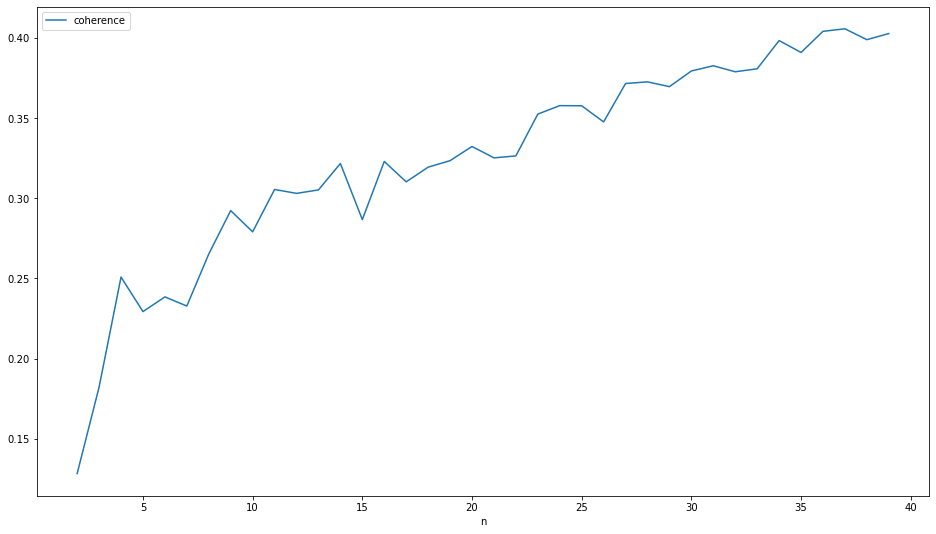

In [80]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
lda_para_model_n = []
for n in range(2, 40):
    lda_model_c = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=2000, eta='auto', iterations=400, num_topics=n, passes=20, eval_every=None,random_state=42)
    lda_coherence = CoherenceModel(model=lda_model_c, texts=docs,dictionary=dictionary, coherence='c_v')
    lda_para_model_n.append((n, lda_model_c, lda_coherence.get_coherence()))
pd.DataFrame(lda_para_model_n, columns=["n", "model","coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))